In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# check for GPU availability things
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 84275074118471998
xla_global_id: -1
]


In [5]:
import pandas as pd
# diagnosis file converted from txt to csv
diagnosis = pd.read_csv(r'C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_Challenge_diagnosis.csv')
diagnosis


,ID,Symptom
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [7]:
diag = diagnosis.to_dict()
ids=list(diag['ID'].values())
print('Number of instances: ',len(ids))
symp=list(diag['Symptom'].values())

Number of instances:  126


In [11]:
#pip  install -c conda-forge librosa

In [13]:
 # Audio feature extraction library
import librosa
import librosa.display
#file name
import glob

In [17]:
import glob
import librosa
import pandas as pd

# Assuming ids and symp are defined earlier
dataset = []

for filename in glob.iglob(r'C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_final_database\*'):
    if filename.endswith('.wav'):
        try:
            identity = filename.split('\\')[-1][:3]  # Using \ for Windows paths
            index = ids.index(int(identity))
            label = symp[index]
            duration = librosa.get_duration(filename=filename)

            if duration >= 3:
                slice_size = 3
                iterations = int((duration - slice_size) / (slice_size - 1))
                iterations += 1
                initial_offset = (duration - ((iterations * (slice_size - 1)) + 1)) / 2

                for i in range(iterations):
                    offset = initial_offset + i * (slice_size - 1)
                    dataset.append({"filename": filename, "label": label, "offset": offset})
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Create the DataFrame
dataset = pd.DataFrame(dataset)
dataset.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8965 entries, 0 to 8964
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  8965 non-null   object 
 1   label     8965 non-null   object 
 2   offset    8965 non-null   float64
dtypes: float64(1), object(2)
memory usage: 210.2+ KB


In [19]:
dataset.head()

,filename,label,offset
0,C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_f...,URTI,0.5
1,C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_f...,URTI,2.5
2,C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_f...,URTI,4.5
3,C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_f...,URTI,6.5
4,C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_f...,URTI,8.5


In [21]:
import matplotlib.pyplot as plt

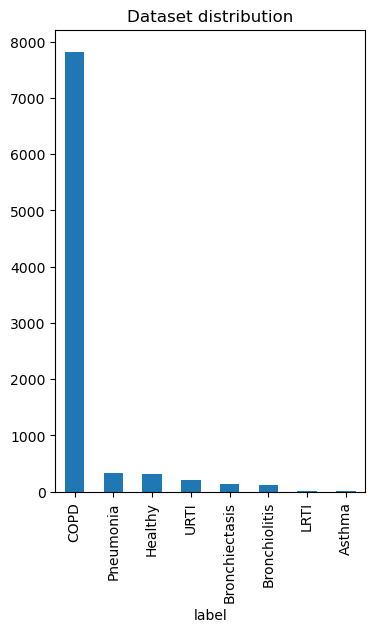

In [23]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
import numpy as np
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 7172
Test: 1793


C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_final_database\101_1b1_Al_sc_Meditron.wav
C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_final_database\102_1b1_Ar_sc_Meditron.wav
C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_final_database\103_2b2_Ar_mc_LittC2SE.wav
C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_final_database\104_1b1_Al_sc_Litt3200.wav
C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_final_database\108_1b1_Al_sc_Meditron.wav
C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_final_database\111_1b2_Tc_sc_Meditron.wav
C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_final_database\122_2b1_Al_mc_LittC2SE.wav
C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_final_database\149_1b1_Al_sc_Meditron.wav


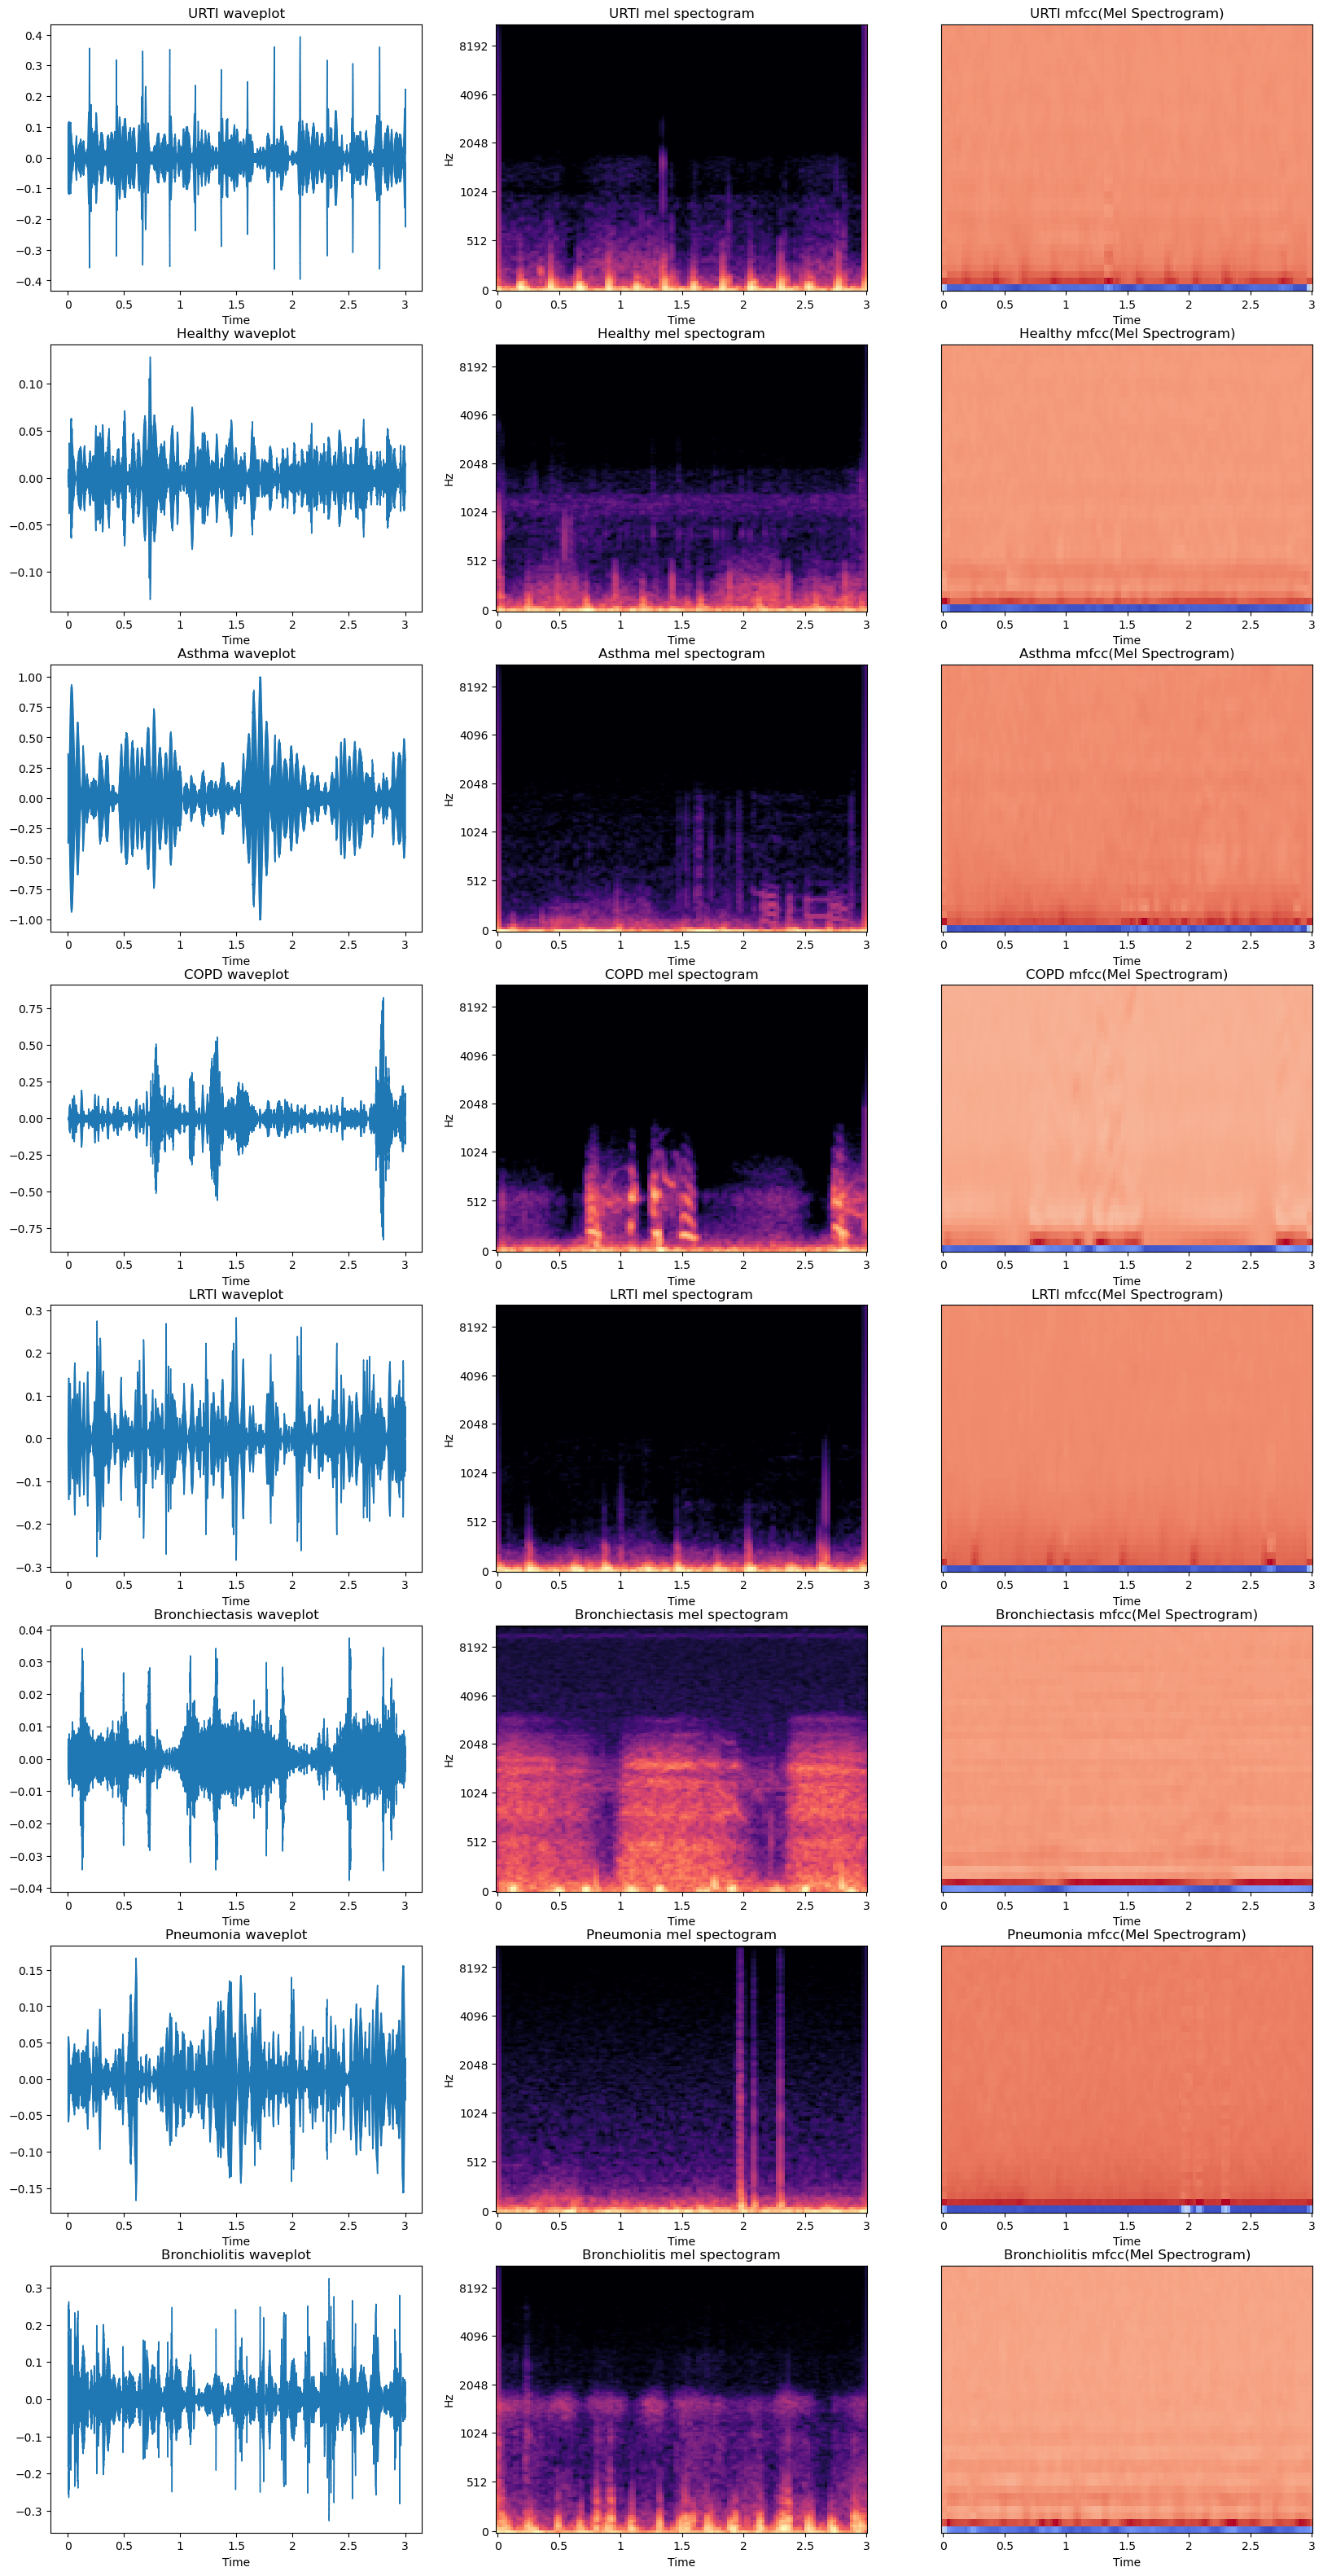

In [27]:

plt.figure(figsize=(20,40))
idx = 0
for label in dataset.label.unique():
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[1],duration=3)
    print(dataset[dataset.label==label].filename.iloc[1])
    idx+=1
    plt.subplot(8, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveshow(y, sr=sr)

    idx+=1
    plt.subplot(8, 3, idx)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time',y_axis='mel')
    plt.title("%s mel spectogram" % label)
    
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(8, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
plt.show()

In [29]:
def extract_features(audio_path,offset):
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048,
    hop_length=512,
    n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    # mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [31]:
from tqdm import tqdm

In [33]:
x_train = []
x_test = []

# Extract features for training set
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx], train.offset.iloc[idx]))

# Extract features for test set
for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx], test.offset.iloc[idx]))

# Convert the lists of features to numpy arrays
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

# Print the shapes of the feature arrays
print("X train shape:", x_train.shape)
print("X test shape:", x_test.shape)


100%|██████████| 1793/1793 [00:19<00:00, 90.50it/s] 


X train shape: (7172, 40, 130)
X test shape: (1793, 40, 130)


In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

from tensorflow.keras.utils import to_categorical


In [37]:
encoder = LabelEncoder()
encoder.fit(train.label)
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)
# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(y_train),y=y_train)


In [43]:
class_weights

array([128.07142857,   8.15      ,   8.965     ,   0.14341705,
         3.46138996,  56.03125   ,   3.4348659 ,   5.33630952])

In [39]:
weight = {i : class_weights[i] for i in range(8)}
weight


{0: 128.07142857142858,
 1: 8.15,
 2: 8.965,
 3: 0.14341705327147655,
 4: 3.4613899613899615,
 5: 56.03125,
 6: 3.4348659003831417,
 7: 5.336309523809524}

In [41]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (7172, 40, 130, 1)
Y train: (7172, 8)
X test: (1793, 40, 130, 1)
Y test: (1793, 8)


In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D,GlobalAveragePooling2D

In [45]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(encoder.classes_), activation='softmax'))
#Visualise the structure
model.summary()

C:\Users\Chani\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 39, 129, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 63, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 31, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 31, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 30, 64)      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 15, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 15, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 14, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,344 (173.22 KB)

 Trainable params: 44,344 (173.22 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [51]:
history = model.fit(x_train, y_train,
batch_size=128,
epochs=300,validation_data=(x_test, y_test),
shuffle=True, class_weight=weight)

Epoch 1/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.0821 - loss: 7.5021 - val_accuracy: 0.0100 - val_loss: 2.0200
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.1457 - loss: 2.3557 - val_accuracy: 0.0089 - val_loss: 2.1014
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.1147 - loss: 2.0359 - val_accuracy: 0.5276 - val_loss: 1.8017
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.3289 - loss: 1.8960 - val_accuracy: 0.6793 - val_loss: 1.5228
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.4628 - loss: 1.7613 - val_accuracy: 0.7546 - val_loss: 1.1451
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.5392 - loss: 1.6749 - val_accuracy: 0.7557 - val_loss: 1.0377
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.5607 - loss: 1.6130 - val_accuracy: 0.8299 - val_loss: 0.6932
Epoch 8/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.5888 - loss: 1.4686 - val_accuracy: 0

Text(0.5, 1.0, 'Accuracy Curves')

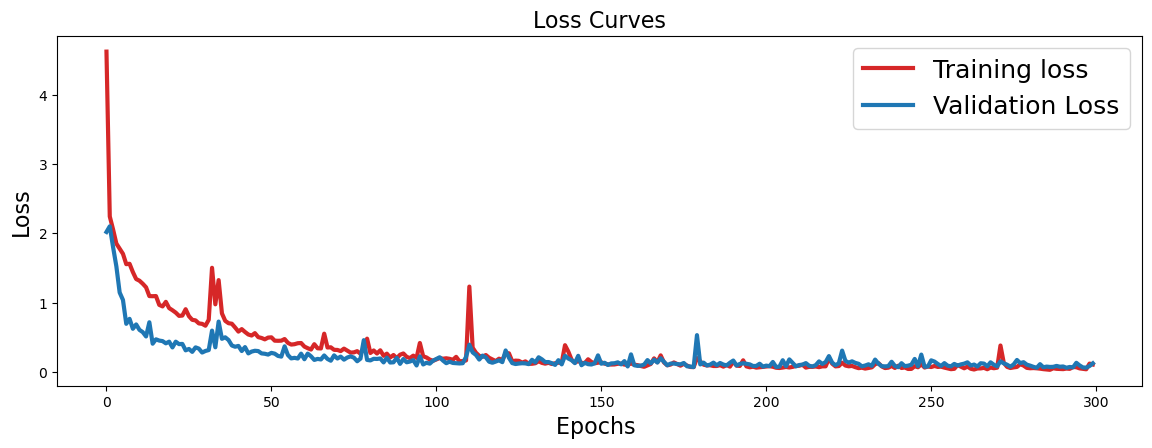

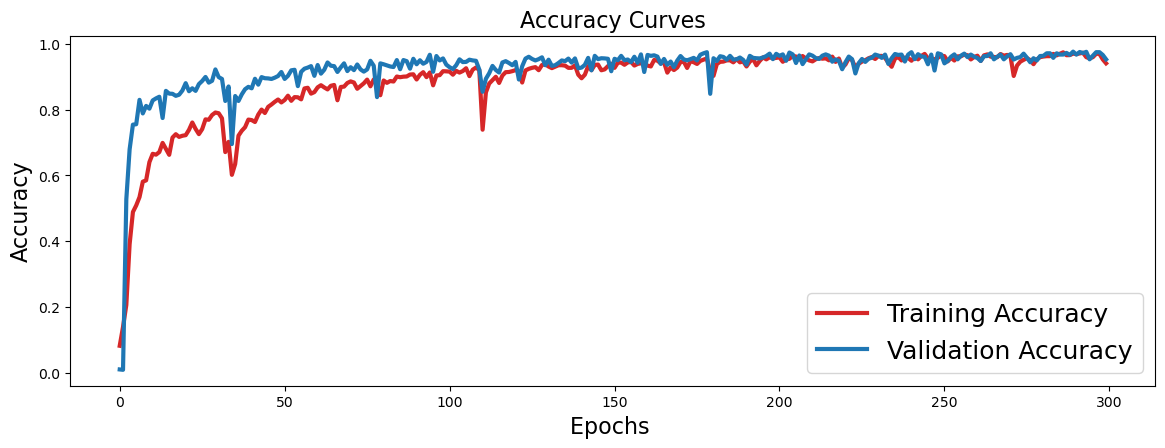

In [53]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [55]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9567 - loss: 0.1198
Test loss: 0.12240021675825119
Test accuracy: 0.9531511664390564


In [57]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix


In [59]:
predictions = model.predict(x_test, verbose=1)
y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions):
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
print(classification_report(y_pred, y_true))

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00         2
Bronchiectasis       1.00      0.71      0.83        48
 Bronchiolitis       0.94      0.80      0.86        20
          COPD       0.95      1.00      0.97      1495
       Healthy       0.98      0.89      0.93        62
          LRTI       1.00      1.00      1.00         2
     Pneumonia       0.97      0.59      0.73       119
          URTI       0.95      0.82      0.88        45

      accuracy                           0.95      1793
     macro avg       0.97      0.85      0.90      1793
  weighted avg       0.95      0.95      0.95      1793



In [61]:
classes

array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI'], dtype=object)

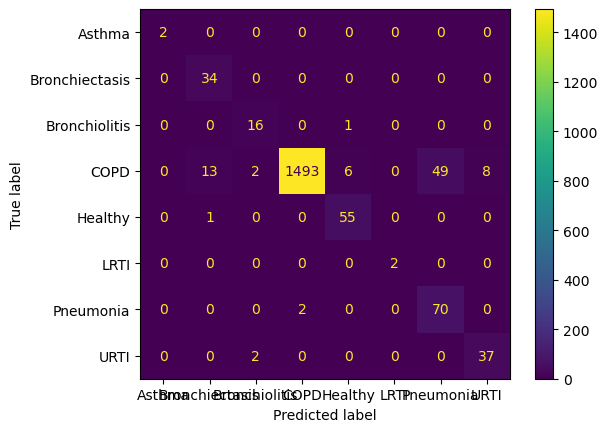

In [63]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
# Plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix =confusion_matrix, display_labels=classes)
cm_display.plot()
plt.show()


In [65]:
model_name = "lung.h5"
model.save(model_name)


In [67]:
from tensorflow.keras.models import load_model
model = load_model("lung.h5")


In [69]:
from tensorflow.keras.models import load_model
import numpy as np
classify_file = R"C:\Users\Chani\Desktop\AML\ICBHI\ICBHI\ICBHI_final_database\\113_1b1_Ll_sc_Litt3200.wav"
test_x = []
test_x.append(extract_features(classify_file,0.5))
test_x = np.asarray(test_x)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)
pred = model.predict(test_x,verbose=1)
print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
[[5.7483931e-38 1.9770219e-10 4.1777935e-22 1.0000000e+00 9.6227694e-33
  3.2913625e-26 4.5541421e-11 5.8490674e-13]]


In [71]:
pred_class = model.predict(test_x)
index = np.argmax(pred_class, axis=1)
print(classes[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
['COPD']


In [73]:
actual = diagnosis.loc[diagnosis['ID'] == 113]
actual

,ID,Symptom
12,113,COPD


In [75]:
from tensorflow.keras.applications import vgg16, resnet
from tensorflow.keras.models import Model
import tensorflow.keras


In [77]:
vgg = vgg16.VGG16(include_top=False, weights=None, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
# adding our own custom made Flatten layer on top of pretrained vgg16 Conv␣layers
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

In [79]:
import pandas as pd
pd.set_option('max_colwidth', 1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_1, built=True>",input_layer_1,True
1,"<Conv2D name=block1_conv1, built=True>",block1_conv1,True
2,"<Conv2D name=block1_conv2, built=True>",block1_conv2,True
3,"<MaxPooling2D name=block1_pool, built=True>",block1_pool,True
4,"<Conv2D name=block2_conv1, built=True>",block2_conv1,True
5,"<Conv2D name=block2_conv2, built=True>",block2_conv2,True
6,"<MaxPooling2D name=block2_pool, built=True>",block2_pool,True
7,"<Conv2D name=block3_conv1, built=True>",block3_conv1,True
8,"<Conv2D name=block3_conv2, built=True>",block3_conv2,True
9,"<Conv2D name=block3_conv3, built=True>",block3_conv3,True


In [81]:
modelvgg = Sequential()
modelvgg.add(vgg_model)
modelvgg.add(Dense(512, activation='relu'))
modelvgg.add(Dense(len(encoder.classes_), activation='softmax'))
modelvgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_28 (Functional)      │ (None, 2048)           │    14,713,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,766,728 (60.15 MB)

 Trainable params: 15,766,728 (60.15 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
modelvgg.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [85]:
history_vgg = modelvgg.fit(x_train, y_train,
    batch_size=128,
    epochs=1,
    validation_data=(x_test, y_test),
    shuffle=True)

57/57 ━━━━━━━━━━━━━━━━━━━━ 350s 6s/step - accuracy: 0.8656 - loss: 5.1644 - val_accuracy: 0.8762 - val_loss: 0.8402


Text(0.5, 1.0, 'Accuracy Curves')

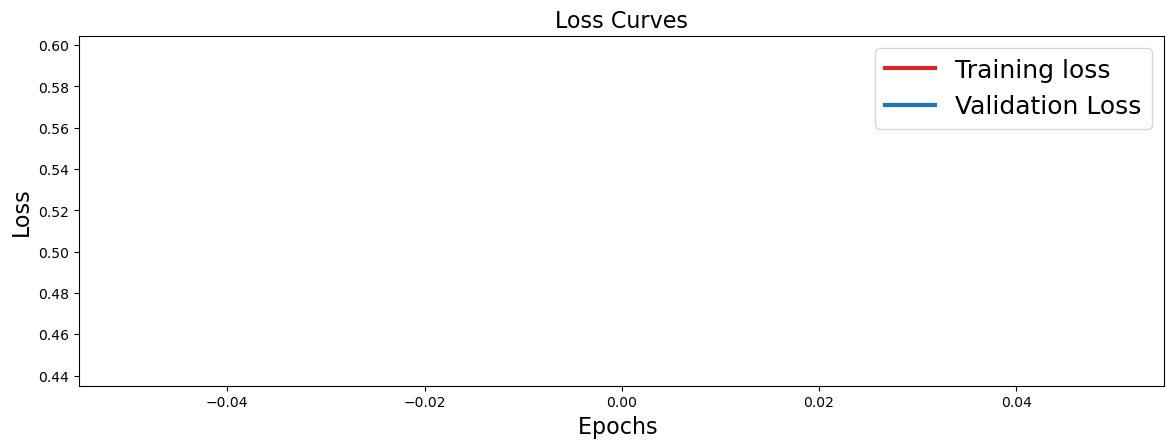

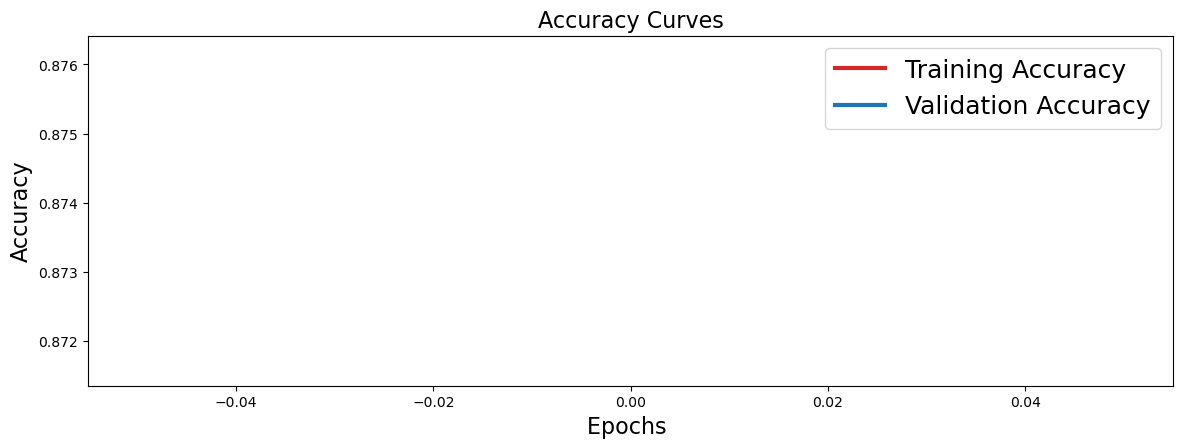

In [73]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history_vgg.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history_vgg.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history_vgg.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history_vgg.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [86]:
scores = modelvgg.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 424ms/step - accuracy: 0.8717 - loss: 0.8214
Test loss: 0.8401558995246887
Test accuracy: 0.8761851787567139


In [89]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

In [91]:
predictions = modelvgg.predict(x_test, verbose=1)
y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions):
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
print(classification_report(y_pred, y_true))


57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 606ms/step
                precision    recall  f1-score   support

        Asthma       0.00      0.00      0.00         0
Bronchiectasis       0.00      0.00      0.00         0
 Bronchiolitis       0.00      0.00      0.00         0
          COPD       1.00      0.88      0.93      1793
       Healthy       0.00      0.00      0.00         0
          LRTI       0.00      0.00      0.00         0
     Pneumonia       0.00      0.00      0.00         0
          URTI       0.00      0.00      0.00         0

      accuracy                           0.88      1793
     macro avg       0.12      0.11      0.12      1793
  weighted avg       1.00      0.88      0.93      1793



C:\Users\Chani\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chani\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chani\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [93]:
classes


array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI'], dtype=object)

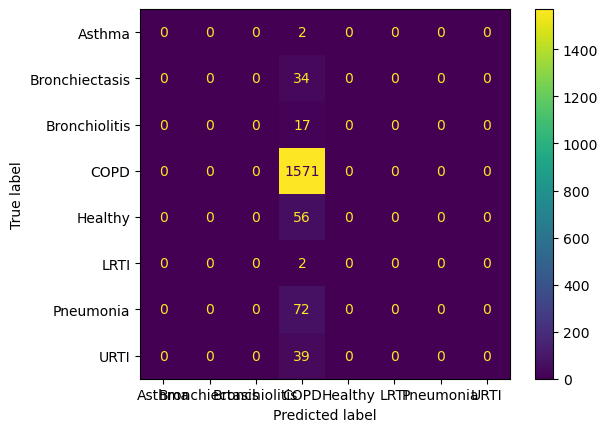

In [95]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
# Check which classes are confused.
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix =confusion_matrix, display_labels=classes)
cm_display.plot()
plt.show()